# Exploratory Data Analysis

Structure
- Notebook Preparation

- [View & Learn Data](##view--learn-data)

- [Clean & Organise Data](##clean--organise-data)
    - [Segregate by 'Winter' months](#segregate-by-winter-months)
    - [Identify Stations in European Alps](#identify-stations-in-european-alps)
    - [Data Filtering](#data-filtering)
        - [Assess Data Validity](#assess-data-validity)
        - [Focus Range](#focus-range)
        - [Filter by Country](#filter-by-country)
        - [Filter by Elevation Band](#filter-by-elevation)



## Notebook Preparation

In [27]:
# Import Packages

import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import plotly.express as px
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pymannkendall as mk
from pathlib import Path
import json

In [28]:
# Files & Directories

NB_DIR = Path.cwd()         # Notebook Directory
REPO_ROOT = NB_DIR.parent   # Main Directory

## View & Learn Data

In [29]:
# Import Metadata
metadata = pd.read_csv(REPO_ROOT/'Data/Cleaned/weather_stations_list.csv')

# View metadata
metadata.head()

,station_id,name,latitude,longitude,elevation,country,provider
0,2979,Cap_ferrat,43.68333,7.32367,138,France,FR_METEOFRANCE
1,2978,Les_orres_fontaines,44.47567,6.55767,1895,France,FR_METEOFRANCE
2,2977,Broc,46.60966,7.10816,682,Switzerland,CH_METEOSWISS
3,2976,Mesocco,46.39560,9.23108,825,Switzerland,CH_METEOSWISS
4,2975,Dischingen_Eglingen,48.71340,10.44050,550,Germany,DE_DWD


In [30]:
# Import Station Data 
station_data = pd.read_csv(REPO_ROOT/'Data/Cleaned/monthly_snowpack.csv')

# View station_data
station_data.head()




,id,station_id,year,month,hnsum
0,371401,2249,1996,3,39.0
1,371402,2249,1997,1,99.0
2,371403,2249,1997,2,22.0
3,371404,2249,1997,3,7.0
4,371405,2249,1998,1,84.0


In [31]:
# Drop Null Values
station_data = station_data.dropna()

In [32]:
# Station Data Info
print('Station Data Info')
print(station_data.info())
print('')

print(f'Station Data Shape :  {station_data.shape}')

print(f'Number Of Unique Entries :  {station_data['id'].nunique()} ')

print(f'Number of Weather Stations : {station_data['station_id'].nunique()}')

Station Data Info
<class 'pandas.core.frame.DataFrame'>
Index: 1027301 entries, 0 to 1500099
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1027301 non-null  int64  
 1   station_id  1027301 non-null  int64  
 2   year        1027301 non-null  int64  
 3   month       1027301 non-null  int64  
 4   hnsum       1027301 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 47.0 MB
None

Station Data Shape :  (1027301, 5)
Number Of Unique Entries :  1027301 
Number of Weather Stations : 2692


## Clean & Organise Data

### Segregate by 'Winter' months

In [33]:
# Assess 'Winter Months' between November - May

station_data['winter'] = station_data['month'].isin([11, 12, 1, 2, 3, 4, 5])

# Validate new column values

winter_list = sum(station_data[station_data['winter']==True].value_counts())
print(f'Number Of Winter Month Records = {winter_list}')


summer_list = sum(station_data[station_data['winter']==False].value_counts())
print(f'Number Of Summer Month Records = {summer_list} \n')


# Validate filtering
print('Validate Total Number Of Records : \n'
      f'Total Number Of Records = {station_data.value_counts().sum()} \n'
      f'Addition of Winter + Summer Records = {winter_list + summer_list}')

Number Of Winter Month Records = 626049
Number Of Summer Month Records = 401252 

Validate Total Number Of Records : 
Total Number Of Records = 1027301 
Addition of Winter + Summer Records = 1027301


### Identify Stations In European Alps

**Source** [Alpine Convention Organsiation](https://www.atlas.alpconv.org/layers/geonode_data:geonode:Alpine_Convention_Perimeter_2025)

Perimeter of the Alpine Convention region. Updated in 2025.

In [34]:
alps_gdf_json = gpd.read_file(REPO_ROOT/'Data/Raw/alps_geo.json')

# CRS (Coordinate Reference System) Organisation
if alps_gdf_json.crs is None:
    alps_gdf_json = alps_gdf_json.set_crs(3035) # EPSG:3035 (ETRS89 / LAEA Europe)


# Dissolve to one multipart polygon; buffer(0) can fix tiny topology issues
alps_mask = alps_gdf_json.set_crs(3035).dissolve().buffer(0) # Using dissolve, the mask is one row

print(f'GDF Alps_Mask CRS = {alps_mask.crs} \n')

# Export GDF Alpe Mask File
print('Export GDF Alps Mask File')
alps_mask_path = REPO_ROOT/"Data/Artifacts/alps_mask.gpkg"
try:
    alps_mask.to_file(alps_mask_path, layer="alps", driver="GPKG")
    if alps_mask_path.exists():
        print('Successful Export \n' 
              f'Export Path = {alps_mask_path}')
except Exception as e:
    print('Failed Export',e)




GDF Alps_Mask CRS = EPSG:3035 

Export GDF Alps Mask File
Successful Export 
Export Path = /Users/mitchellpalmer/Projects/Europe_Snowpack_Depths/Data/Artifacts/alps_mask.gpkg


In [35]:
# Build  GeoDataFrame for weather stations in CRS 4326 using avaiable longitude (x) and latitude (y) data

gdf_stations = gpd.GeoDataFrame(
    metadata,
    geometry=gpd.points_from_xy(metadata["longitude"], metadata["latitude"]),
    crs=4326, # WGS84 CRS type for longitude & latitude data
    )

# Assign GeoDataFrame_stations to CRS 3035, matching the Alps_Mask CRS
gdf_stations = gdf_stations.to_crs(alps_mask.crs)  # -> EPSG:3035 to match the mask

print(f'GDF_Station CRS = {gdf_stations.crs} \n'
      f'GDF Alps_Mask CRS = {alps_mask.crs}')


GDF_Station CRS = EPSG:3035 
GDF Alps_Mask CRS = EPSG:3035


In [36]:
# ── 3) Select stations inside the Alps mask ─────────────────────────────────────
# Using dissolve above, the mask is one row; grab its geometry
mask_geom = alps_mask.geometry.iloc[0]
stations_in_alps  = gdf_stations[gdf_stations.within(mask_geom)]
stations_out_alps = gdf_stations.drop(index=stations_in_alps.index)

print(f"Stations inside Alps: {len(stations_in_alps):,} \n" 
      f"Stations Outside Alps: {len(stations_out_alps):,} \n"
      f"Total Stations Meta Data: {len(gdf_stations):,}")

Stations inside Alps: 1,468 
Stations Outside Alps: 1,326 
Total Stations Meta Data: 2,794


Weather_Stations_in_European_Alps Fig Saved 
Export saved at: /Users/mitchellpalmer/Projects/Europe_Snowpack_Depths/Visualisation_Outputs/weather_stations_in_alps.png


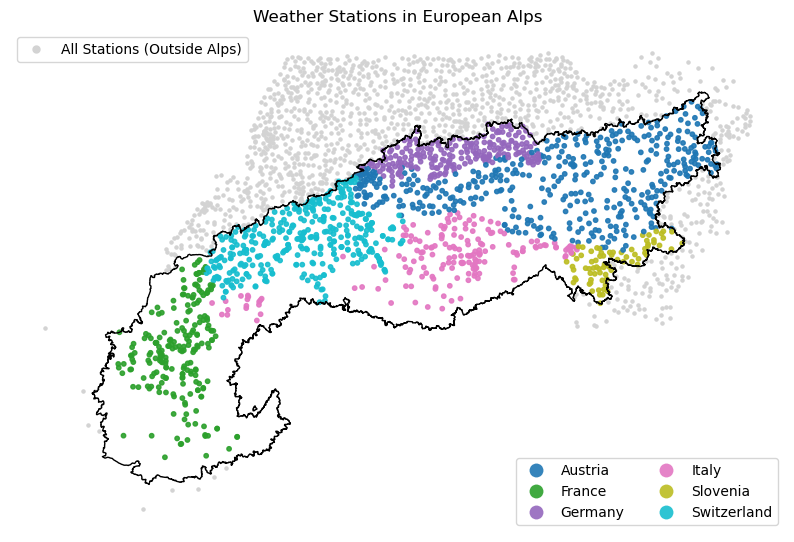

In [37]:
# Alps Station Visualisation
fig,ax = plt.subplots(figsize=(10 ,10))
alps_mask.boundary.plot(ax=ax, color= "black", linewidth = 1)
stations_out_alps.plot(ax=ax, markersize=5, color = "lightgray", label= "All Stations (Outside Alps)")
stations_in_alps = stations_in_alps.copy() 
stations_in_alps["country"] = stations_in_alps["country"].astype("category")
stations_in_alps.plot(
    ax=ax, column="country", categorical=True, legend=True,
    markersize=10, alpha=0.9, legend_kwds={"loc": "lower right", "ncol": 2}
)
ax.set_title('Weather Stations in European Alps')
ax.set_axis_off()

outide_legend = ax.get_legend()        # Create a new legend
ax.add_artist(outide_legend)           # Add new legend to ax

from matplotlib.lines import Line2D    # Import Line2D Features
outside_handle = Line2D(               # Create outside_handle legend 
    [], # x_data
    [], # y_data
    marker='o', 
    linestyle='None',
    color='lightgray',                 # Same color as stations_out_alps.plot
    markersize=5,
    label='All Stations (Outside Alps)')

ax.legend(handles=[outside_handle], loc='upper left')   # Assign the handles to legend

fig_path = REPO_ROOT / 'Visualisation_Outputs/weather_stations_in_alps.png'
plt.savefig(fig_path)
print('Weather_Stations_in_European_Alps Fig Saved \n'
      f'Export saved at: {fig_path}')
plt.show()




### Data Filtering

Filter snowpack_depth recordings by Weather Stations In European Alps

In [38]:
# Create list of European Alp Weather Stations
stations_in_alps_list = stations_in_alps['station_id']

# Filter station_data to Weather Stations in Alps
station_data = station_data[station_data['station_id'].isin(stations_in_alps_list)]

print(f'DF station_data filtered to only Stations_in_alps: {station_data['station_id'].nunique():,}')



DF station_data filtered to only Stations_in_alps: 1,416


#### Assess Data Validity

Determine which years within our dataset meet thresholds to consider analysis

- Standard Error (SE) / Confidence Intervals
- Minimum Sample Size
    - Size = 30
- Coefficient of Variation (CV)
    - Compares the variability to the mean.
    - High CV in low-sample years means those averages are unstable.

Span of continuous reliable years: 1936 - 2019
Yearly Snowpack Reliability Chart Output 
Output Saved At: /Users/mitchellpalmer/Projects/Europe_Snowpack_Depths/Visualisation_Outputs/yearly_snowpack_reliability.png


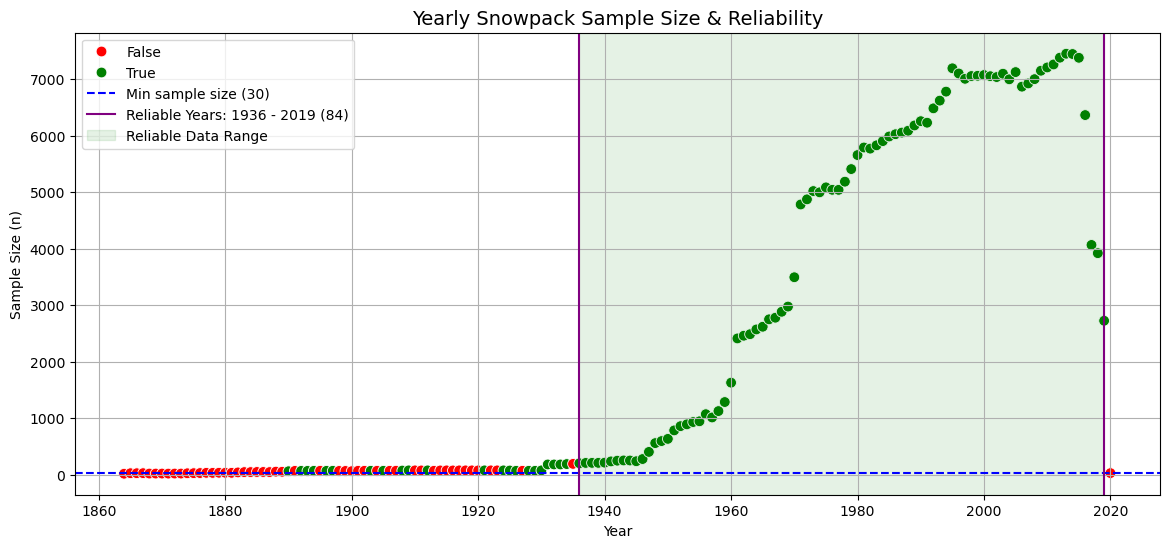

,year,n,mean,std,SE,CV,mean_change,Reliable
0,1864,18,20.333333,32.526912,7.666667,1.599684,NaN,False
1,1865,27,24.555556,34.562467,6.651550,1.407521,0.207650,False
2,1866,27,39.185185,46.071881,8.866538,1.175747,0.595777,False
3,1867,28,34.392857,52.411717,9.904884,1.523913,0.122299,False
4,1868,21,32.523810,45.706257,9.973923,1.405317,0.054344,False
...,...,...,...,...,...,...,...,...
152,2016,6367,42.305010,53.430706,0.669612,1.262988,0.386843,True
153,2017,4068,52.475664,55.231766,0.865961,1.052522,0.240413,True
154,2018,3922,46.652983,60.891981,0.972313,1.305211,0.110960,True
155,2019,2726,54.360602,56.664480,1.085295,1.042381,0.165212,True


In [39]:
# Assistance With AI

#  Aggregate Yearly Stats for Snowpack Depth
yearly_stats = station_data[station_data['winter']==True].groupby('year').agg(
    n=('hnsum', 'size'),
    mean=('hnsum', 'mean'),
    std=('hnsum', 'std')
).reset_index()

# Calculate Standard Error (SE) and Coefficient of Variation (CV)
yearly_stats['SE'] = yearly_stats['std'] / np.sqrt(yearly_stats['n']) # SE = Standard Deviation / (Square root of Sample size)
yearly_stats['CV'] = yearly_stats['std'] / yearly_stats['mean'] # CV = Standard Deviation / Average 

# Calculate year-to-year % change in mean snow depth
yearly_stats['mean_change'] = yearly_stats['mean'].pct_change().abs()

# Set Data Validity thresholds
min_sample_size = 30  # Minimum number of recordings per year
max_se_threshold = yearly_stats['SE'].median() * 1.5  # Allow 50% above median SE
mean_change_threshold = yearly_stats['mean'].mean() * 0.20  # 20% change allowed

# Assign Reliability flag
yearly_stats['Reliable'] = (
    (yearly_stats['n'] >= min_sample_size) &
    (yearly_stats['SE'] <= max_se_threshold) &
    (yearly_stats['mean_change'] <= mean_change_threshold)
)


# Assume yearly_stats['year'] is sorted
reliable_years = yearly_stats.loc[yearly_stats['Reliable'], 'year'].tolist()

# Identify an unbroken continous chain of 'Reliable Years' of data
earliest_reliable_year = None
latest_reliable_year = max(reliable_years) # Known Max() value is in continous chain
for i, start_year in enumerate(reliable_years):
    # Check if all years from start_year to max year are in the reliable list
    expected_years = list(range(start_year, max(reliable_years) + 1))
    if expected_years == reliable_years[i:]:
        earliest_reliable_year = start_year
        break

print(f"Span of continuous reliable years: {earliest_reliable_year} - {latest_reliable_year}")


# Plot
plt.figure(figsize=(14, 6))
sns.scatterplot(data=yearly_stats, x='year', y='n', hue='Reliable',
                palette={True: 'green', False: 'red'}, s=60)
plt.axhline(min_sample_size, color='blue', linestyle='--', label=f'Min sample size ({min_sample_size})')
plt.axvline(earliest_reliable_year, color='purple', linestyle='-', 
            label=f'Reliable Years: {earliest_reliable_year} - {latest_reliable_year} ({-1*(earliest_reliable_year-latest_reliable_year-1)})')
plt.axvline(latest_reliable_year, color='purple', linestyle='-')

# Shaded region for reliable years
plt.axvspan(earliest_reliable_year,latest_reliable_year, color='green', alpha=0.1,
            label="Reliable Data Range")

plt.title("Yearly Snowpack Sample Size & Reliability", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Sample Size (n)")
plt.legend()
plt.grid(True)

samplesize_plt_path = REPO_ROOT / 'Visualisation_Outputs/yearly_snowpack_reliability.png'
plt.savefig(samplesize_plt_path)
print('Yearly Snowpack Reliability Chart Output \n'
      f'Output Saved At: {samplesize_plt_path}')
plt.show()



# --- Output the yearly stats for review ---
yearly_stats


#### Focus Range
Use identifed Focus_Range to isolate chosen sample data 

In [40]:
# Segregate the identiied Focus_Range
focus_range = np.arange(earliest_reliable_year,latest_reliable_year +1)
snow_recordings = station_data[(station_data['year'].isin(focus_range)) & (station_data['winter'] == True)]

# Sort by choronlogical order
snow_recordings = snow_recordings.sort_values(by=['year', 'month','station_id']).reset_index(drop=True)

pd.DataFrame(snow_recordings)
snow_recordings.head(2)


,id,station_id,year,month,hnsum,winter
0,1784526,132,1936,1,37.0,True
1,1618609,153,1936,1,78.0,True


#### Filter By Country

In [41]:
# Filter all snow_recordings to
snow_recordings = pd.merge(snow_recordings, stations_in_alps, on='station_id')
snow_recordings.head(2)

,id,station_id,year,month,hnsum,winter,name,latitude,longitude,elevation,country,provider,geometry
0,1784526,132,1936,1,37.0,True,Scuol_CH_METEOSWISS,46.79327,10.28324,1303,Switzerland,CH_METEOSWISS,POINT (4342645.19 2631133.413)
1,1618609,153,1936,1,78.0,True,Arosa_CH_METEOSWISS,46.79262,9.67900,1878,Switzerland,CH_METEOSWISS,POINT (4296468.91 2631072.969)


In [42]:
# Quantity of records per country
snow_recordings.value_counts('country')

country
Austria        111521
Switzerland     76261
Germany         64985
France          55838
Slovenia        19792
Italy           18482
Name: count, dtype: int64

#### Filter by Elevation

##### Create Elevation Bands

Elevation Band Identifications

- Lowlands
    - Lowlands <= 1,000 m
- Midlands
    - 1,000 m < Midlands <= 2,000 m
- Alpine
    - 2,000 < Alpine

In [43]:
snow_recordings['elevation'].describe()

count    346879.000000
mean       1014.473373
std         465.227796
min         163.000000
25%         660.000000
50%         930.000000
75%        1310.000000
max        2964.000000
Name: elevation, dtype: float64

In [44]:
Lowlands = 1000
Alpine = 2000


# Create custom elevation classification function by quartile distribution
def classify_elevation(elev):
    if elev <= Lowlands:
        return 'Low Elevation'
    elif Lowlands < elev <= Alpine:
        return 'Mid Elevation'
    else:
        return 'High Elevation'
    
# Assign elevation classifciation 
snow_recordings['elevation_band'] = snow_recordings['elevation'].apply(classify_elevation)

In [45]:
snow_recordings.value_counts('elevation_band')

elevation_band
Low Elevation     191031
Mid Elevation     146022
High Elevation      9826
Name: count, dtype: int64

In [46]:
# Snow_recordings output path
sr_path = Path(REPO_ROOT/'data/cleaned/snow_recordings.csv')
sr_path.parent.mkdir(exist_ok=True,parents=True)


# Export snow_recordings as csv
try:
    snow_recordings.to_csv(sr_path, index=False,header=True)
    if sr_path.exists():

        print('Month Snowpack Data Successfully Cleaned & Filtered \n'
            'Grouped Snow Recording Data Exported \n'
            f'Exported to Path : {sr_path}\n')
except Exception as e:
    print('Failure to Export Snow_Recordings.csv',e)

Month Snowpack Data Successfully Cleaned & Filtered 
Grouped Snow Recording Data Exported 
Exported to Path : /Users/mitchellpalmer/Projects/Europe_Snowpack_Depths/data/cleaned/snow_recordings.csv

